Vu Ngoc Linh 

# NLP with DL - Week 1

1. Thu thập một số bài báo: **10 topics**

2. Chuyển đổi các bài báo thành các vector tf.idf

3. Biết rằng các giá trị trọng số tf.idf sẽ biểu diễn cho độ quan trọng của các từ trong các bài báo, hãy xác định:
 - 10 từ quan trọng nhất trong từng bài báo

 - 10 từ quan trọng nhất trong từng thể loại

4. Hãy sử dụng logistic regression để xây dựng **bộ phân loại chung** cho các thể loại trên

## 1 - Import library ##

In [204]:
# libraries for dataset preparation, feature engineering
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(123) #for reprodicible results
%matplotlib inline

# handle file path
import glob

## 2 - Dataset preparation ##

Create a new `datasets/News/all_news.csv` from all topics under `Train_full` directory:

In [205]:
dir = 'datasets/News/Train_full/'
# get all topics
topics = [f.split('/')[-1] for f in glob.glob(dir + "/*", recursive=False)]

# combine news from topics to 1 file with label
df = pd.DataFrame(columns=['text', 'label'])
for t in topics:
    files = [f for f in glob.glob(dir + t + "/*.txt", recursive=False)]
    a = []
    for fpath in files:
        with open(fpath, encoding="utf16", errors='ignore') as f:
            a.append(f.read())
        
    df2 = pd.DataFrame({'text': a})
    df2["label"] = t
    df = df.append(df2, ignore_index = True)
df.to_csv('datasets/News/all_news.csv', index=False)

print('topics: {}'.format(topics))

topics: ['Van hoa', 'The gioi', 'Khoa hoc', 'Suc khoe', 'Chinh tri Xa hoi', 'Vi tinh', 'Kinh doanh', 'The thao', 'Phap luat', 'Doi song']


## 3 - Data exploration

Read from `datasets/News/all_news.csv`

In [206]:
df = pd.read_csv('datasets/News/all_news.csv')
df.head()

text    label
0   Ông đồ cuối cùng trên đảo\n“Vua Tần cỡi cọp c...  Van hoa
1   Kịch hài định kỳ Cậu Tèo về quê - vở kịch hài...  Van hoa
2  Hồ Ngọc Hà: 'Thời trang cổ điển là sự vĩnh cửu...  Van hoa
3   Ta tự hào đi lên - Ôi VN Chương trình ca nhạc...  Van hoa
4  3 tỷ đồng cho live show Mỹ Tâm\nKinh phí dự tí...  Van hoa

In [207]:
df['label'].value_counts()

The thao            5298
Chinh tri Xa hoi    5219
Phap luat           3868
Suc khoe            3384
Doi song            3159
Van hoa             3080
The gioi            2898
Kinh doanh          2552
Vi tinh             2481
Khoa hoc            1820
Name: label, dtype: int64

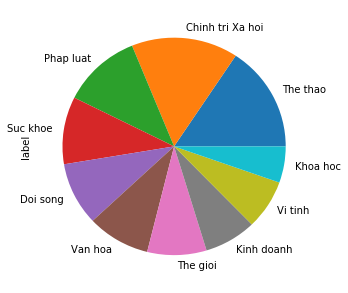

In [210]:
df['label'].value_counts().plot.pie(figsize=(5, 5))

In [217]:
# an example of a computer news
df[df['label'] == 'Vi tinh'].iloc[0, 0]

'Những ý tưởng tạo phần mềm từ các môn học\nSáng nay, tại thành đoàn TP HCM đã diễn ra vòng chung kết cuộc thi viết phần mềm sáng tạo Hội thi tin học trẻ không chuyên. Đa số phần mềm xuất phát từ những nhu cầu của học sinh như trò chơi, học tiếng Việt, học lịch sử...\nNhững người theo dõi chú ý đến Games collection for kids, tác phẩm của Huỳnh Đức Anh Huy, học lớp 8A1 trường Trần Đại Nghĩa, quận 1. Đây là trò chơi bong bóng số. Mỗi quả bóng mang một biểu thức, người chơi phải tìm số sao cho có kết quả đúng. Huy tâm sự: Ngoài giờ học, em thường thư giãn bằng chơi game. Nhưng em thấy chương trình game hiện nay chủ yếu là của nước ngoài, nhiều trò kích thích bạo lực hơn là sáng tạo. Em muốn tạo một bộ sưu tập trò chơi của Việt Nam, đa cấp độ, vừa chơi vừa học được. Tạm thời, vì mới tập trung ôn thi học kỳ nên em chỉ hoàn thành được trò bong bóng dành cho đối tượng 5-10 tuổi". \nNhỏ tuổi nhất cuộc thi là cậu bé Hoàng Quốc Anh, học sinh lớp 5 trường Bành Văn Trân (Tân Bình), với phần mềm dự

Next, we will split the dataset into training and test sets so that we can train and test classifier. Also, we will encode our target column so that it can be used in our model.

In [218]:
# split the dataset into training and test datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], df['label'])

# label encode the target variable, encode labels to 0, 1, 2
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

topics_df = pd.DataFrame({"topic": topics}, index=encoder.transform(topics))
topics_df

topic
8           Van hoa
6          The gioi
2          Khoa hoc
5          Suc khoe
0  Chinh tri Xa hoi
9           Vi tinh
3        Kinh doanh
7          The thao
4         Phap luat
1          Doi song

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset.

## 3 - feature engineering

### preprocessing: deadling with stopwords

use [vietnamese-stopwords.txt](https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt)

In [219]:
with open("datasets/vietnamese-stopwords.txt", 'r', encoding='utf8') as f:
    stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
print('there are {} stopwords'.format(len(stopwords)))

there are 1942 stopwords


In [260]:
# print 10 stopwords
for i in range(1,10):
    print(stopwords.pop())

nói_qua
đặt_trước
làm_riêng
năm_tháng
rồi
quá_mức
không_thể
mạnh
đến_tuổi


### TF-IDF Vectors as features

In [247]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words = stopwords,
                             max_features=5000, ngram_range=(1,2))
tfidf_vect.fit(df['text'])

# output of tfidf transform is sparse matrix, which is not allow us to apply normal matrix calculation
# => we need to convert to normal matrix
xtrain_tfidf =  tfidf_vect.transform(train_x).toarray()
xtest_tfidf =  tfidf_vect.transform(test_x).toarray()

# Getting transformed training and testing dataset
print('Number of training documents: %s' %str(xtrain_tfidf.shape[0]))
print('Number of testing documents: %s' %str(xtest_tfidf.shape[0]))
print('Number of features of each document: %s' %str(xtrain_tfidf.shape[1]))
print('xtrain_tfidf shape: %s' %str(xtrain_tfidf.shape))
print('train_y shape: %s' %str(train_y.shape))
print('xtest_tfidf shape: %s' %str(xtest_tfidf.shape))
print('test_y shape: %s' %str(test_y.shape))

Number of training documents: 25319
Number of testing documents: 8440
Number of features of each document: 5000
xtrain_tfidf shape: (25319, 5000)
train_y shape: (25319,)
xtest_tfidf shape: (8440, 5000)
test_y shape: (8440,)


### get top 10 words 

In [197]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_topic(Xtr, y, topics_df, features, min_tfidf=0.1, top_n=10):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same topic. '''
    dfs = pd.DataFrame(index = range(0,top_n))
    for i in topics_df.index:
        ids = np.where(y==i)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        dfs[topics_df.loc[i,][0]] = feats_df["feature"]
    return dfs

** get top 10 words of each news **

In [222]:
tfidf_vect.inverse_transform(xtrain_tfidf[13])

[array(['02', '05', '05 2004', '06', '09', '10', '11', '12', '16', '18',
        '2', '20', '2002', '2003', '2004', '26', '27', '3', '3 6', '44',
        '5', '5 3', '6', '7', '8', '9', 'bình', 'bảo', 'bắt', 'bố', 'bồi',
        'can', 'chi', 'chi cục', 'chiếm', 'chiếm đoạt', 'chiều', 'chủ',
        'chức', 'chức vụ', 'cán', 'cáo', 'công', 'công bố', 'cục', 'danh',
        'danh sách', 'doanh', 'doanh nghiệp', 'duyên', 'dụng', 'giá',
        'giúp', 'giả', 'hai', 'hoa', 'hoàn', 'hoạch', 'hoạch đầu', 'hà',
        'hà nội', 'hành', 'hành công', 'hình', 'hình phạt', 'hóa',
        'hóa đơn', 'hđxx', 'hưởng', 'hạn', 'hậu', 'hậu nghiêm', 'hối',
        'hối lộ', 'hợp', 'hủy', 'khởi', 'khởi tố', 'kim', 'kinh',
        'kinh doanh', 'kiến', 'kiến nghị', 'kê', 'ký', 'kế', 'kế hoạch',
        'liệu', 'lâm', 'lý', 'lưu', 'lưu hành', 'lương', 'lượt', 'lộ',
        'lợi', 'lợi dụng', 'lừa', 'lừa đảo', 'ma', 'mua', 'mỹ', 'nghiêm',
        'nghiêm trọng', 'nghiệp', 'nghị', 'nguyên', 'nguyễn', 'nguy

In [223]:
# top 10 words in xtrain_tfidf[13]
top_tfidf_feats(xtrain_tfidf[13], feature_array, top_n=10)

feature     tfidf
0          thuế  0.422189
1     thái bình  0.417577
2           cán  0.274279
3          thái  0.258573
4          bình  0.178958
5            tù  0.160097
6           cục  0.137611
7         doanh  0.108712
8  trưởng phòng  0.108303
9          phạt  0.107737

** get top 10 words of whole corpus (across 10 topics) **

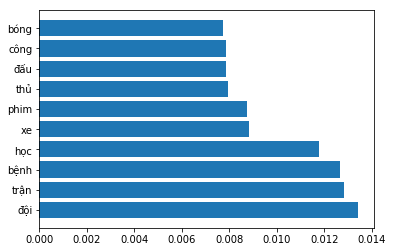

In [243]:
# top 10 important words across the whole corpus
dff = top_mean_feats(xtrain_tfidf, feature_array, grp_ids=None, min_tfidf=0.1, top_n=10)
xx = dff["feature"]
yy = np.arange(len(xx))
# Create horizontal bars
plt.barh(yy, dff["tfidf"])
# Create names on the y-axis
plt.yticks(yy, xx)
# Show graphic
plt.show()

** get top 10 important words of each topic ** 

In [225]:
# top 10 important words of each topic
top_feats_by_topic(xtrain_tfidf, train_y, topics_df, feature_array, min_tfidf=0.1, top_n=10)

Van hoa    The gioi    Khoa hoc   Suc khoe Chinh tri Xa hoi     Vi tinh  \
0       phim        iraq        loài       bệnh              học         máy   
1       nhạc          mỹ      nghiên      thuốc               du   microsoft   
2         ca  tổng thống  nghiên cứu         da               xe     dịch vụ   
3       diễn          cử         học    ung thư             sinh         mềm   
4        hát        iran         vật        trẻ               đh        game   
5         sĩ   palestine         cứu  bệnh nhân              thi    internet   
6      ca sĩ      bầu cử        chim        ung              dân        file   
7  diễn viên   thủ tướng    khoa học       thai          du lịch     windows   
8        vai        bush    trái đất       viêm           trường        điện   
9   đạo diễn       tướng          cổ       uống             công  điện thoại   

     Kinh doanh The thao Phap luat  Doi song  
0           giá      đội   công an       yêu  
1         doanh     trận        án     chồng  
2  doanh nghiệp      đấu        an        vợ  
3          khẩu     bóng       tra        mẹ  
4           usd    thắng        xe      tình  
5          hàng      thủ       cáo       gái  
6          thuế  cầu thủ      dũng  tình yêu  
7        nghiệp      hlv      công       cảm  
8        đầu tư    tuyển    nguyễn        ta  
9      cổ phiếu      vợt        vụ      sống

## 4 - Implement Softmax Regression with NN mindset

In [252]:
def softmax(scores):
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    return probs

def initialize_with_zeros(dim, num_class):
    W = 0.01 * np.random.randn(dim, num_class)
    b = np.zeros((1, num_class))
    return W, b

def propagate(W, b, X, y, reg):
    m = X.shape[0]
    
    scores = np.dot(X, W) + b 

    # compute the class probabilities
    probs = softmax(scores)

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(m),y])
    data_cost = np.sum(correct_logprobs)/m
    reg_cost = 0.5*reg*np.sum(W*W)
    cost = data_cost + reg_cost

    # compute the gradient on scores
    dscores = probs
    dscores[range(m),y] -= 1
    dscores /= m

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dW += reg*W # regularization gradient
    
    grads = {"dW": dW,
             "db": db}
    return grads, cost


def softmax_optimize(W, b, X, y, num_iterations, 
               learning_rate = 1e-0, reg = 1e-3, print_cost=False):
    
    # gradient descent loop
    costs = []
    for i in range(0, num_iterations):
        grads, cost = propagate(W, b, X, y, reg)
        costs += [cost]
        if print_cost and (i % 100 == 0 or i + 1 == num_iterations):
            print("iteration {}: cost = {}".format(i, cost))
        
        # Retrieve derivatives from grads
        dW = grads["dW"]
        db = grads["db"]

        # perform a parameter update
        W += -learning_rate * dW
        b += -learning_rate * db
    
    params = {"W": W,
              "b": b}
    
    grads = {"dW": dW,
             "db": db}
    
    return params, grads, costs

### predict 

In [249]:
def predict(W, b, X):
    scores = np.dot(X, W) + b
    Y_prediction = np.argmax(scores, axis=1)
    Y_prob = np.max(scores, axis=1)
    return Y_prediction, Y_prob, scores

In [253]:
def model(X_train, Y_train, X_test, Y_test, num_class, 
          num_iterations = 2000, learning_rate = 0.5, reg = 0, print_cost = False):
    """
    Builds the softmax regression model by calling the function you've implemented previously
    Returns: d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    W, b = initialize_with_zeros(dim = X_train.shape[1], num_class = num_class)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = softmax_optimize(W, b, X_train, Y_train, 
                                                num_iterations, learning_rate, reg, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    W = parameters["W"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(W,b,X_test)[0]
    Y_prediction_train = predict(W,b,X_train)[0]

    # Print train/test Errors
    print("train accuracy: {} %".format(np.mean(Y_prediction_train == Y_train) * 100))
    print("test accuracy: {} %".format(np.mean(Y_prediction_test == Y_test) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train": Y_prediction_train, 
         "W": W, 
         "b": b,
         "learning_rate": learning_rate,
         "reg": reg,
         "num_iterations": num_iterations}
    
    return d

In [254]:
d = model(xtrain_tfidf, train_y, xtest_tfidf, test_y, num_class = len(topics), 
          num_iterations = 3000, learning_rate = 1, reg = 0, print_cost = True)

softmax Z (25319, 10); A (25319, 10)
iteration 0: cost = 2.3026121838679874
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
iteration 900: cost = 0.7937805112535307
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 1

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
iteration 1100: cost = 0.7183921180762287
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
iteration 2000: cost = 0.5437299771461801
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
iteration 2200: cost = 0.5217775776363863
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
softmax Z (25319, 10); A (25319, 10)
s

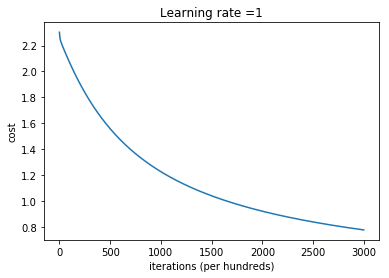

In [230]:
# Plot learning curve (with costs)
costs = d["costs"]
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### test with some news

## 5 - Using sklearn: Logistic Regression with Stochastic Average Gradient 

In [231]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

# train
logreg = linear_model.LogisticRegression(C=1e5, 
        solver = 'sag', multi_class = 'multinomial')
logreg.fit(xtrain_tfidf, train_y)

# test
y_pred = logreg.predict(xtest_tfidf)
print("Accuracy: %.2f %%" %(100*accuracy_score(test_y, y_pred.tolist())))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy: 88.67 %


## 7 - Test with my own news 

In [238]:
text = ["""Cuối tháng Tư vừa qua, sau một số báo cáo từ các reviewer về sự cố đối với màn hình trên Galaxy Fold, Samsung đã hoãn việc ra mắt sản phẩm này ngay trước ngày mở bán chính thức. 
    Trước đó dự kiến nó sẽ được mở bán chính thức tại Mỹ vào ngày 26 tháng Tư và ở châu Âu một tuần sau đó. 
    Cho đến nay, công ty vẫn chưa chính thức xác nhận ngày mở bán trở lại.
    Cho dù công ty cho biết, họ hoãn phát hành Galaxy Fold để sửa chữa một số vấn đề về thiết kế, nhưng họ không tiết lộ về cách thức họ sửa chữa những vấn đề này. 
    Tuy nhiên, một báo cáo mới đây từ trang tin Yonhap của Hàn Quốc có thể cho thấy các chi tiết về những cải thiện được Samsung thực hiện trên chiếc smartphone màn hình gập đầu tiên của mình.
    """,
    """Theo ông Hải, về cơ bản thì nền kinh tế Việt Nam có nhiều yếu tố thuận lợi hỗ trợ, NHNN có công cụ để điều tiết chủ động. Cung cầu ngoại tệ không có biến động đột biến, không có tình trạng doanh nghiệp muốn mua ngoại tệ mà không mua được. 
    Đó là những cơ sở tốt để có niềm tin NHNN giữ được ổn định thị trường tiền tệ.
    Phó tổng giám đốc phụ trách ngoại hối của một ngân hàng thương mại lớn cũng nhận định với hơn 8 tỉ đô la Mỹ đã mua trong bốn tháng qua, NHNN dư sức để bổ sung cho nguồn cung, giải quyết được nhu cầu ngoại tệ của các tháng, như với tháng 4 là khoảng 560 triệu đô la Mỹ nhập siêu và một  phần ngoại tệ chuyển từ quan hệ tín dụng sang mua bán.
    """,
    """Tháng ăn chay Ramadan của người Hồi giáo, các quốc gia châu Á kỷ niệm lễ Phật đản và biểu tình ở Brazil là những sự kiện nổi bật trong tuần qua.
    Người Palestine đốt pháo hoa giữa đống đổ nát để chào mừng tháng chay Ramadan tại thành phố Gaza vào ngày 13/5. 
    Đây là tháng Ramadan của năm thứ 1440 theo lịch Hồi giáo. 
    Tháng ăn chay là một trong những trụ cột của Hồi giáo, nhằm ghi nhớ thời kỳ nhà tiên tri Mohammed lui đến ở hang động phía bắc Mecca. 
    Các vũ công biểu diễn trên sân khấu tại Lễ hội văn hóa châu Á, thuộc sự kiện Hội nghị Đối thoại các nền văn minh châu Á, tại sân vận động quốc gia Trung Quốc ở thủ đô Bắc Kinh vào ngày 15/5.
    """,
    """Thủ tướng May từ chức trong bối cảnh nước Anh chia rẽ sâu sắc về vấn đề Brexit, để lại một nhiệm vụ khó khăn cho người kế nhiệm: tìm kiếm sự đồng lòng trong quốc hội. 
    Theo giới quan sát, sự ra đi của bà May có thể khiến cuộc khủng hoảng Brexit thêm tồi tệ bởi nhà lãnh đạo mới có thể sẽ đưa ra quyết định quyết đoán hơn về việc rời EU, làm tăng khả năng đối đầu với EU, và có thể dẫn đến một cuộc bầu cử quốc hội sớm.
    EU đến nay vẫn khẳng định không đàm phán lại thỏa thuận Brexit đã chốt từ 11-2018.
    """, 
    """Hãng thông tấn Kyodo (Nhật) dẫn các nguồn thạo tin ngày 24-5 cho biết Amazon tại Nhật Bản đã ngừng bán trực tiếp các sản phẩm do Huawei sản xuất, gồm các mẫu điện thoại thông minh mới nhất, máy tính cá nhân và máy tính bảng.
    Lý do được Amazon đưa ra là vì "các lo ngại về hệ điều hành của Huawei".
    Tuy nhiên, nhà bán lẻ trực tuyến này cho hay khách hàng vẫn có thể mua các sản phẩm của Huawei do các công ty bên thứ ba bán trên trang Amazon tại Nhật Bản.
    Tính đến ngày 24-5, tất cả sản phẩm trên của Huawei điều được ghi là hết hàng trên trang bán trực tiếp bởi Amazon Nhật Bản.
    """,
    """Đón tiếp CLB Hải Phòng trên sân nhà Hàng Đẫy tại vòng 11 V-League, BTC trận đấu của của CLB Viettel đã có sự chuẩn bị rất chu đáo về công tác an ninh, đề phòng cổ động viên đội khách "quậy phá" như chuyến làm khách trước CLB Hà Nội cách đây không lâu.
    Nhiều giờ trước khi bóng lăn, công an Hà Nội đã cấm xe cộ lưu thông trên phố Trịnh Hoài Đức, khu vực phía sau khán đài B sân vận động Hàng Đẫy để lập các chốt kiểm tra an ninh với các CĐV vào sân. 
    Cổ động viên vào sân đều được kiểm tra người, túi xách và các vật dụng mang theo. Do vậy trong suốt trước, trong và sau trận đấu đã không có bất cứ quả pháo sáng nào được đốt trên sân Hàng Đẫy. 
    Cũng không có chai lọ, vật cứng nào ném xuống sân khi đội nhà bị thủng lưới. 
    """,
    """Phóng viên TTXVN tại châu Phi dẫn thống kê mới nhất từ Tổ chức Y tế thế giới (WHO) cho biết ngoài việc giết chết 200 người mỗi ngày trên khắp thế giới, những vết cắn từ rắn độc, mỗi năm còn để lại những thương tổn nặng nề cho khoảng 400.000 người từ bại liệt, cắt bỏ chi đến sang chấn tâm lý lâu dài.
    Theo thống kê, châu Á và châu Phi là hai khu vực có số người tử vong vì bị rắn độc cắn nhiều nhất với con số lần lượt là 57.000-100.000 người và 20.000-32.000 người, tiếp theo là Mỹ Latinh -Caribe (3.400-5.000), châu Đại Dương (200-500) và cuối cùng là châu Âu (30-130).
    Lý giải cho số tử vong cao tại châu Á và châu Phi, WHO cho rằng ngoài khí hậu và thổ nhưỡng thuận lợi cho nhiều loài rắn độc sinh trưởng, hệ thống y tế tại hai châu lục này còn thưa thớt và chưa được đầu tư đầy đủ, đặc biệt liên quan đến công tác sơ cứu nạn nhân bị rắn độc cắn tại khu vực nông thôn.
    """,
    """8 bị can bị đề nghị truy tố cùng về tội "lợi dụng chức vụ, quyền hạn trong khi thi hành công vụ" theo điểm a, khoản 2, điều 356 Bộ luật hình sự.
    Giám đốc Sở Giáo dục và đào tạo cũng nhờ nâng điểm
    Theo kết quả điều tra (đã được tống đạt đến các bị can), nhân vật quan trọng nhất trong vụ án này là ông Trần Xuân Yến, phó giám đốc Sở Giáo dục - đào tạo tỉnh Sơn La.
    Trong kỳ thi THPT quốc gia năm 2018, ông Yến được phân công là ủy viên Ban chỉ đạo thi của tỉnh, phó chủ tịch Hội đồng thi, trưởng Ban vận chuyển và bàn giao đề thi, phó trưởng ban thường trực Ban coi thi, phó trưởng ban thường trực Ban chấm thi, tổ trưởng Tổ xử lý bài thi trắc nghiệm.
    """,
    """Ngày 20-5, các nhà khoa học Nhật Bản thông báo đã phát triển một hệ thống mới, có thể ước lượng tình trạng ngập lụt khi mưa đang trút xuống tại khu vực đô thị ở thủ đô Tokyo.
    Một nhóm các nhà nghiên cứu thuộc Đại học Waseda, Đại học Tokyo và các trường khác đã phát triển hệ thống có thể tính mức độ ngập lụt do các trận mưa lớn gây ra tại 23 quận ở Tokyo. Họ đã lập một chương trình dự báo lượng nước tại các khu vực đô thị, trong đó có tính tới mật độ các tòa nhà, các dòng sông và cống thoát nước. 
    Bằng cách sử dụng dữ liệu của Cơ quan Khí tượng Nhật Bản (JMA) và các cơ quan khác, hệ thống này có thể phân tích mức độ thiệt hại do tình trạng ngập lụt từ các trận mưa lớn và bão gây ra.
    """]

x_tfidf =  tfidf_vect.transform(text).toarray()

In [239]:
y = predict(d["W"], d["b"], x_tfidf)
print('prediction of my model: {}'.format([topics_df.loc[i,][0] for i in y[0]]))

prediction of my model: ['Vi tinh', 'Kinh doanh', 'The gioi', 'The gioi', 'Vi tinh', 'The thao', 'Chinh tri Xa hoi', 'Chinh tri Xa hoi', 'Chinh tri Xa hoi']


In [240]:
y_log = logreg.predict(x_tfidf)
print('prediction of logistic regression with SAG: {}'.format([topics_df.loc[i,][0] for i in y_log.tolist()]))

prediction of logistic regression with SAG: ['Vi tinh', 'Kinh doanh', 'The gioi', 'The gioi', 'Kinh doanh', 'The thao', 'The gioi', 'Phap luat', 'The gioi']


<font color='blue'>
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings 
    - Try others parameters of TfidfVectorizer, such as ngrams, lowercase
    - See what features are in a Tf-idf vector
    - Test with different feature representation other than Tf-idf